## This is the first exploration of taking zones from lego pictures and estimating the closest lego colors

In [1]:
import pandas as pd
import numpy as np
import picture_stuff as pix
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Implement the function cosine_distance which computes a cosine-similarity-based distance between
# two numpy arrays.

def cosine_distance(x,y):
    #return x.dot(y)/(np.linalg.norm(x,axis=1)/np.linalg.norm(y))
    return x.dot(y)/(np.linalg.norm(x)/np.linalg.norm(y))

In [3]:
# Implement the function euclidean_distance which computes
# the Euclidean distance between two numpy arrays.

def euclidean_distance(x,y):
    #return np.sqrt(np.sum((x-y)**2,axis=1))
    return np.sqrt(np.sum((x-y)**2))

In [4]:
xx=np.array([0,3])
yy=np.array([0,1])
print xx
print yy
#cosine_distance(np.array([[0,1]]),np.array([[1,1]]))
print euclidean_distance(xx,yy)
print cosine_distance(xx,yy)

[0 3]
[0 1]
2.0
1.0


In [5]:
# Colors from http://www.peeron.com/cgi-bin/invcgis/colorguide.cgi
# and see also http://www.bartneck.de/2016/09/09/the-curious-case-of-lego-colors/
df_colors = pd.read_csv("peeron_colors.csv")

In [6]:
df_colors[df_colors['Color'].str.contains('red')]

,LEGO No.,Color,C,M,Y,K,R,G,B,Pantone
5,9,Light reddish violet,0,33,8,0,232,186,199,203 C
8,21,Bright red,0,100,100,0,196,40,27,032 C
9,22,Med. reddish violet,10,72,0,0,196,112,160,2375 C
22,100,Light red,0,27,24,0,238,196,182,169 C
23,101,Medium red,0,60,50,0,218,134,121,170 C
39,123,Br. reddish orange,0,72,80,0,211,111,76,165 C
40,124,Bright reddish violet,33,95,8,5,146,57,120,241 C
58,153,Sand red,37,54,48,10,149,121,118,4995 C
59,154,Dark red,45,100,90,11,123,46,47,194 C
66,193,Flame reddish orange,0,79,100,0,207,96,36,173 C


In [7]:
X  = np.array(df_colors[['R','G','B']].astype('int'))
y  = np.array(df_colors['Color'])
ys = np.array(df_colors['LEGO No.'].astype('int'))

In [9]:
# Other color set:
curr_dir = '../../rebrickable data/2017-09/'
colors = pd.read_csv(curr_dir + 'colors.csv')

In [10]:
print "Rebrickable color file  {:8} rows".format(colors.shape[0])
print "Peerson color file      {:8} rows".format(len(y))

Rebrickable color file       135 rows
Peerson color file           111 rows


In [11]:
colors[colors['name'].str.contains('Red')]

,id,name,rgb,is_trans
5,4,Red,C91A09,f
35,36,Trans-Red,C91A09,t
53,70,Reddish Brown,582A12,f
109,320,Dark Red,720E0F,f
115,335,Sand Red,D67572,f
133,1007,Reddish Lilac,8E5597,f


In [12]:
def knn_dists(new_color,colors,distance=euclidean_distance,n_match=5):
    distances = np.zeros(len(colors))  
    for idx in range(len(colors)):
        distances[idx]=distance(new_color,colors[idx])
    return np.argsort(distances)[:n_match]

In [13]:
test_idx = 23
#NOTE: idx=3: Brick yellow, idx=5: Light reddish violet, idx=23: Medium red

closest = knn_dists(X[test_idx],X,distance=cosine_distance)

result_colors = []
result_names = []
result_indices = []
for idx in closest:
    result_colors.append(X[idx])
    result_names.append(y[idx])
    result_indices.append(ys[idx])

print closest
print result_colors
print result_names
print result_indices

[55 13 50 49 90]
[array([22, 29, 50]), array([27, 42, 52]), array([39, 70, 44]), array([32, 58, 86]), array([ 52,  43, 117])]
['Black metallic', 'Black', 'Earth green', 'Earth blue', 'Medium lilac']
[149, 26, 141, 140, 268]


### Load a picture, and select 9 regions in it for color comparison

In [20]:
picpath = "../../brick_pics_mine/"
pic_list = ["3031-019.jpeg","3032-002.jpeg","3298-001.jpeg","3795-001.jpeg"]
#pic_list = ["3031-019.jpeg"]

In [15]:
def choose_region(image,ranges):
    return_pics = []
    for imrange in ranges:
        subset = image_filter(image,imrange)
        ave_color = average_color(subset)
        return_pics.append(subset)
    return return_pics

In [16]:
def image_filter(image,pix_range):
    '''returns the pixel from an image given min/max positions
    '''
    x_min = pix_range[0]
    x_max = pix_range[1]
    y_min = pix_range[2]
    y_max = pix_range[3]
    print x_min,x_max,y_min,y_max
    subset = image[x_min:x_max,y_min:y_max]
    return subset

In [17]:
def set_ranges(x_size=299,y_size=299,
               x_from_center=.15,y_from_center=.15,
               x_span=10,y_span=10):
    '''Define 9 ranges within each range of pixels
       INPUTS: x_size=299,y_size=299: size of image
               x_from_center=.1,y_from_center=.1: fractional distance
                 from center for each off-center blob
               x_span=10,y_span=10: number of pixels in each range
       OUTPUTS: pix_ranges: list of lists [[x_min,xmax,y_min,y_max]]
    '''
    pix_ranges = []
    # Specify the lower left corner of each box
    left_x = int((x_size - x_span)/2)
    lower_y = int((y_size - y_span)/2)
    
    # Convert percentages from center to pixel steps
    step_x = int(x_size * x_from_center)
    step_y = int(y_size * y_from_center)

    for idx_x in range(-1,2):
        for idx_y in range(-1,2):
            pix_ranges.append([left_x + idx_x*step_x, left_x + idx_x*step_x + x_span,
                               lower_y + idx_y*step_y, lower_y + idx_y*step_y + y_span])
    return pix_ranges

In [18]:
def average_color(subset):
    pass

IOError: [Errno 2] No such file or directory: '../../brick_pics_mine/3031-019.jpeg'

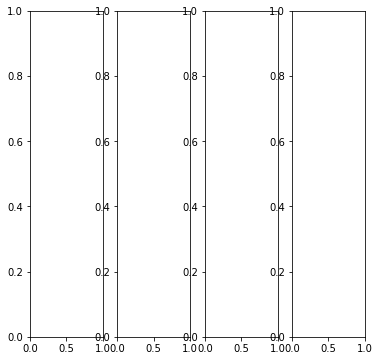

In [22]:
fig, ax = plt.subplots(1,len(pic_list),figsize=(6,6))

for idx,pic in enumerate(pic_list):
    image_path = picpath + pic
    pic_pixels = pix.get_image(image_path).astype('float64')
    ax[idx].imshow(pic_pixels)

In [ ]:
ranges = set_ranges()
image_path = picpath + pic_list[0]
pic_pixels = pix.get_image(image_path).astype('float64')
plt.imshow(pic_pixels)
regions = choose_region(pic_pixels,ranges)
print [regions[idx].shape for idx in range(len(regions))]